In [1]:
import openmc
import numpy as np
import os

# Load the Materials

In [2]:
materials = openmc.Materials.from_xml() # must have materials.xml defined!
uo2, water, uo2_water = materials

# Define the Geometry

With our infinite-medium materials defined, let's simulate neutron slowing down in an infinite medium.  To model an infinite, homogeneous reactor, we define a the region to be the inside of a unit sphere with a reflecting boundary.

In [3]:
radius = 1.0
sphere = openmc.Sphere(r=radius, boundary_type='reflective')
stuff = openmc.Cell(name='fuel')
stuff.fill = uo2_water
stuff.region = -sphere # the "-" means "inside of"
root_universe = openmc.Universe(cells=[stuff])
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()

# Define the Source and Other Settings

Let there be a uniformly distributed and isotropic source of 10 MeV neutrons throughout the sphere.  We'll simulate 10 batches of 10000 particles each.  Because we do not want the impact of neutrons born from fission, we turn off that feature.  To help improve our results, we'll use survival biasing.

In [4]:
# Source 10 MeV source uniformly distributed in the unit sphere
source = openmc.Source(space=openmc.stats.spherical_uniform(1.0))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([1e7], [1.0])
settings = openmc.Settings()
settings.source = source
settings.batches = 10
settings.inactive = 0
settings.particles = 1000000
settings.run_mode = 'fixed source'
settings.create_fission_neutrons = False
settings.survival_biasing = True
settings.export_to_xml()

# Define Tallies 

Our main interest is to compute the slowing-down spectrum, so we tally the flux over the entire domain with the same energy grid used for our [NarrowResonanceSpectra](NarrowResonanceSpectra.ipynb).

In [5]:
cell_filter = openmc.CellFilter(stuff)
E_bounds = np.logspace(-3, 7, 50000)
spectrum_filter = openmc.EnergyFilter(E_bounds)
spectrum_tally = openmc.Tally(1)
spectrum_tally.filters = [cell_filter, spectrum_filter]
spectrum_tally.scores = ['flux']

tallies = openmc.Tallies([spectrum_tally])
tallies.export_to_xml()

# Run OpenMC and Load the Tallies

In [6]:
#openmc.run()

In [9]:
sp = openmc.StatePoint('statepoint.10.h5')
tally = sp.get_tally(id=1)
phi_MC = tally.mean.flatten()
phi_MC = phi_MC / np.diff(E_bounds)
phi_NR = np.load('nr_flux.npy')

Now, plot the flux spectra and their ratio (remember, a spectrum is unique to within a multiplicative constant, e.g., $af(E)$ and $bf(E)$ are equivalent since we always divide by the integral.

(0.01, 1000000.0)

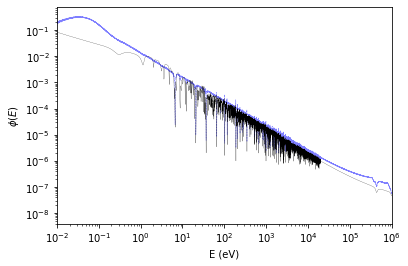

In [30]:
import matplotlib.pyplot as plt
plt.loglog(E_bounds[1:], phi_MC/50, 'b--', lw=0.5, alpha=0.5)
plt.loglog(E_bounds, phi_NR, 'k', lw=0.2)
plt.xlabel('E (eV)')
plt.ylabel('$\phi(E)$');
plt.xlim(0.01, 1e6)

0.9580575125882661


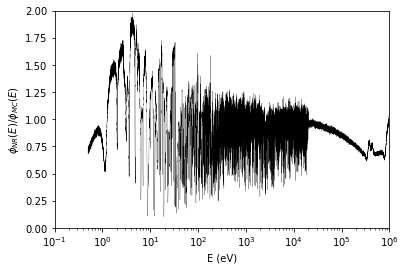

In [45]:
import matplotlib.pyplot as plt
thermal_cutoff = sum(E_bounds<0.5)
p1 = phi_MC[thermal_cutoff:]/sum(abs(phi_MC[thermal_cutoff:]))
p2 = phi_NR[thermal_cutoff+1:]/sum(abs(phi_NR[thermal_cutoff+1:]))
plt.semilogx(E_bounds[thermal_cutoff+1:], p2/p1, 'k', lw=0.2, alpha=1)
plt.xlabel('E (eV)')
plt.ylabel('$\phi_{NR}(E)/\phi_{MC}(E)$');
plt.xlim(0.1, 1e6)
plt.ylim(0, 2);

How does the narrow-resonance approximation work?  Which energy range appears to be better represented (assuming OpenMC is the "reference" solution)?